<a href="https://colab.research.google.com/github/AMEYABHAVE/Cristl/blob/main/project2_HAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


In [2]:
from google.colab import drive
import pandas as pd
file_location = '/content/drive/MyDrive/accelerometer.csv'
accelerometer =pd.read_csv(file_location)
accelerometer.drop(columns=['time','repetition','uuid'], inplace=True)
accsitting= accelerometer[accelerometer['activity'] == 'CHAIR'].head(9875)
accstanding= accelerometer[accelerometer['activity'] == 'STANDING'].head(9875)
acclying= accelerometer[accelerometer['activity'] == 'LYING_UP'].head(9875)
accdataset = pd.DataFrame()
accdataset = accdataset.append([accsitting, accstanding, acclying])
accdataset.drop(columns=['activity'], inplace=True)

file_location1 = '/content/drive/MyDrive/gyroscope.csv'
gyroscope =pd.read_csv(file_location1)
gyroscope.drop(columns=['time','repetition','uuid'], inplace=True)
gyrsitting= gyroscope[gyroscope['activity'] == 'CHAIR'].head(9875)
gyrstanding= gyroscope[gyroscope['activity'] == 'STANDING'].head(9875)
gyrlying= gyroscope[gyroscope['activity'] == 'LYING_UP'].head(9875)
gyrdataset = pd.DataFrame()
gyrdataset = gyrdataset.append([gyrsitting, gyrstanding, gyrlying])

dataset=pd.concat([accdataset, gyrdataset.set_index(accdataset.index)], axis=1)
dataset.drop(columns=['name'], inplace=True)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29625 entries, 0 to 93591
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acc_x     29625 non-null  float64
 1   acc_y     29625 non-null  float64
 2   acc_z     29625 non-null  float64
 3   gyr_x     29625 non-null  float64
 4   gyr_y     29625 non-null  float64
 5   gyr_z     29625 non-null  float64
 6   activity  29625 non-null  object 
dtypes: float64(6), object(1)
memory usage: 1.8+ MB


In [4]:
dataset['activity'].value_counts()

STANDING    9875
LYING_UP    9875
CHAIR       9875
Name: activity, dtype: int64

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
label=LabelEncoder()
dataset['label']=label.fit_transform(dataset['activity'])
print(dataset.head())
print(label.classes_)

      acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z activity  label
0 -0.414825  7.590469  6.235336 -0.309540  7.679596  6.142029    CHAIR      0
1 -0.337662  7.645508  6.125275 -0.530884  7.897354  5.765747    CHAIR      0
2 -0.393295  7.605423  6.231155 -0.608643  8.231140  5.266846    CHAIR      0
3 -0.469269  7.592865  6.281403 -0.570953  8.260452  5.229172    CHAIR      0
4 -0.418411  7.633530  6.317307 -0.816223  8.244308  5.284195    CHAIR      0
['CHAIR' 'LYING_UP' 'STANDING']


In [6]:
X = dataset[['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']]
Y = dataset['label']
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(data=X, columns=['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z'])
scaled_X['label'] = Y.values
scaled_X

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label
0,-0.610501,0.705138,0.431830,-0.511514,0.743974,0.380241,0
1,-0.525900,0.725603,0.415590,-0.751855,0.819761,0.323345,0
2,-0.586896,0.710698,0.431213,-0.836288,0.935931,0.247909,0
3,-0.670191,0.706029,0.438628,-0.795364,0.946133,0.242213,0
4,-0.614432,0.721149,0.443926,-1.061684,0.940514,0.250533,0
...,...,...,...,...,...,...,...
29620,1.077678,1.494336,-0.388644,0.393923,1.434373,-0.432256,1
29621,1.107858,1.472311,-0.378226,0.417320,1.446039,-0.434066,1
29622,1.135394,1.471199,-0.370548,0.326331,1.445205,-0.435876,1
29623,1.105884,1.486325,-0.393499,0.383524,1.451038,-0.441668,1


In [7]:
import scipy.stats as stats
Fs = 20
frame_s = Fs*2
hop_s = Fs

In [17]:
def get_frames(df, frame_s, hop_s):
  N = 6
  frames=[]
  labels=[]
  for i in range(0, len(df) - frame_s, hop_s):
    ax = df['acc_x'].values[i: i+frame_s]
    ay = df['acc_y'].values[i: i+frame_s]
    az = df['acc_z'].values[i: i+frame_s]
    gx = df['gyr_x'].values[i: i+frame_s]
    gy = df['gyr_y'].values[i: i+frame_s]
    gz = df['gyr_z'].values[i: i+frame_s]

    label = stats.mode(df['label'][i:i+frame_s])[0][0]
    frames.append([ax,ay,az,gx,gy,gz])
    labels.append(label)
  
  frames = np.asarray(frames).reshape(-1, frame_s, N)
  labels = np.asarray(labels)
  
  return frames, labels

In [18]:
X, Y = get_frames(scaled_X, frame_s, hop_s)

In [19]:
X.shape, Y.shape

((1480, 40, 6), (1480,))

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [21]:
X_train.shape, X_test.shape

((1184, 40, 6), (296, 40, 6))

In [24]:
X_train = X_train.reshape(len(X_train), 40, 6, 1)
X_test = X_test.reshape(len(X_test), 40, 6, 1)

In [25]:
model = Sequential()
model.add(Conv2D(16, (2,2), activation='relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [26]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20
37/37 [==============================] - 2s 19ms/step - loss: 0.5880 - accuracy: 0.7610 - val_loss: 0.3062 - val_accuracy: 0.8581
Epoch 2/20
37/37 [==============================] - 0s 13ms/step - loss: 0.3559 - accuracy: 0.8404 - val_loss: 0.2765 - val_accuracy: 0.8581
Epoch 3/20
37/37 [==============================] - 1s 14ms/step - loss: 0.2867 - accuracy: 0.8767 - val_loss: 0.2282 - val_accuracy: 0.9189
Epoch 4/20
37/37 [==============================] - 1s 14ms/step - loss: 0.2654 - accuracy: 0.8758 - val_loss: 0.2075 - val_accuracy: 0.9257
Epoch 5/20
37/37 [==============================] - 1s 14ms/step - loss: 0.2352 - accuracy: 0.8995 - val_loss: 0.1990 - val_accuracy: 0.9054
Epoch 6/20
37/37 [==============================] - 1s 15ms/step - loss: 0.2071 - accuracy: 0.9054 - val_loss: 0.1724 - val_accuracy: 0.9459
Epoch 7/20
37/37 [==============================] - 1s 14ms/step - loss: 0.2085 - accuracy: 0.9155 - val_loss: 0.1631 - val_accuracy: 0.9426
Epoch 8/20
37

In [28]:
def plot_accuracycurve(a, history, epochs):
  ep = range(1, epochs+1)
  plt.title(a+' Model Accuracy')
  plt.plot(ep, history.history['accuracy'])
  plt.plot(ep, history.history['val_accuracy'])
  plt.ylabel('Accuracy')
  plt.ylabel('Epochs')
  plt.legend(['Train','Val'])
  plt.show()

def plot_losscurve(a, history, epochs):
  ep = range(1, epochs+1)
  plt.title(a+' Model Loss')
  plt.plot(ep, history.history['loss'])
  plt.plot(ep, history.history['val_loss'])
  plt.ylabel('Loss')
  plt.ylabel('Epochs')
  plt.legend(['Train','Val'])
  plt.show()

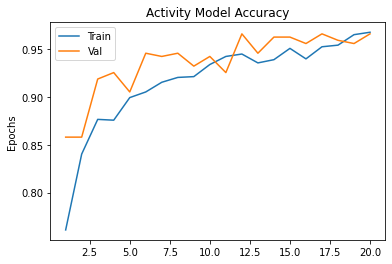

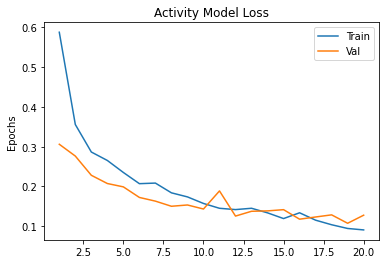

In [29]:
plot_accuracycurve('Activity', history, 20)
plot_losscurve('Activity', history, 20)

In [32]:
pip install mlxtend

In [33]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31670faad0>)

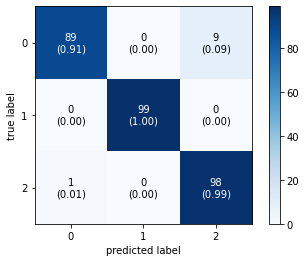

In [34]:
Y_P = model.predict(X_test)
Y_predict=np.argmax(Y_P,axis=1)
mat = confusion_matrix(Y_test, Y_predict)
plot_confusion_matrix(conf_mat=mat, show_normed=True, colorbar=True)

In [35]:
print(label.classes_)

['CHAIR' 'LYING_UP' 'STANDING']
